In [3]:
import numpy as np
import matplotlib.pyplot as plt
import rps.robotarium as robotarium
from rps.utilities.transformations import create_si_to_uni_mapping
from rps.utilities.barrier_certificates import create_single_integrator_barrier_certificate
from rps.utilities.controllers import create_si_position_controller
from matplotlib.patches import Circle
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Parameters
N = 5  # Number of robots
iterations = 4000  # Simulation iterations
sensing_radius = 0.2  # Sensing radius for obstacle avoidance
max_velocity = 0.1  # Maximum velocity to avoid actuator limit errors
fire_radius = 0.21  # Radius of the fire zone
fire_reduction_rate = 0.001  # Rate at which fire is reduced
fire_threshold = 0.01  # Threshold to consider fire extinguished
k_att = 1.0  # Attractive potential scaling factor
k_rep = 0.3  # Repulsive potential scaling factor
random_seed = 42  # Set a random seed for reproducibility

# # Battery-related parameters
# battery_levels = np.array([95, 90, 95, 55, 85], dtype=float)  # Initial battery percentages
# battery_decay_rate = 0.025  # Battery reduction rate per step
# low_battery_threshold = 25  # Threshold below which robots go to charging station
# charging_station = np.array([0.9, -0.9])  # Bottom-right corner for charging station
# charging_radius = 0.1  # Radius of the charging station

# Set random seed for reproducibility
np.random.seed(random_seed)

# Random obstacles (trees)
num_trees = 2  # Number of random obstacles
tree_positions = np.random.uniform(-0.8, 0.8, (2, num_trees))  # Random positions for trees

# Create Robotarium instance
# r = robotarium.Robotarium(number_of_robots=N, show_figure=True)

# Initialize robots at random positions within a bounded region
x_min, x_max = -1, 1  # Bounds for x-coordinate
y_min, y_max = -1, 1  # Bounds for y-coordinate

# Generate random positions for robots
initial_positions_x = np.random.uniform(x_min, x_max, size=N)  # Random x-coordinates
initial_positions_y = np.random.uniform(y_min, y_max, size=N)  # Random y-coordinates
initial_positions = np.vstack((initial_positions_x, initial_positions_y))  # Combine x and y


# Predefined fire locations
fires = [np.array([[-0.8], [0.5]]),  # Fire 1
         np.array([[0.0], [-0.5]]),  # Fire 2
         np.array([[0.5], [0.5]])]   # Fire 3

fire_status = [1.0, 1.0, 1.0]  # Fire intensity (1.0 = full intensity)


# Function to compute attractive potential gradient
def attractive_force(position, goal):
    return -k_att * (position - goal)

# Function to compute repulsive potential gradient, including fire zones and trees
def repulsive_force(position, obstacles, fire_zones, sensing_radius):
    force = np.zeros_like(position)
    for obstacle in obstacles.T:
        diff = position - obstacle
        distance = np.linalg.norm(diff)
        if distance < sensing_radius:
            force += k_rep * (1/distance - 1/sensing_radius) * (1/distance**2) * diff / distance
    for fire_zone in fire_zones:
        diff = position - fire_zone.flatten()
        distance = np.linalg.norm(diff)
        if distance < fire_radius:
            force += k_rep * 2 * (1/distance - 1/fire_radius) * (1/distance**2) * diff / distance
    return force

# Function to check if robots are within the target distance of the fire
def within_fire_zone(positions, fire_location):
    distances = np.linalg.norm(positions - fire_location, axis=0)
    return distances <= fire_radius


ModuleNotFoundError: No module named 'rps'

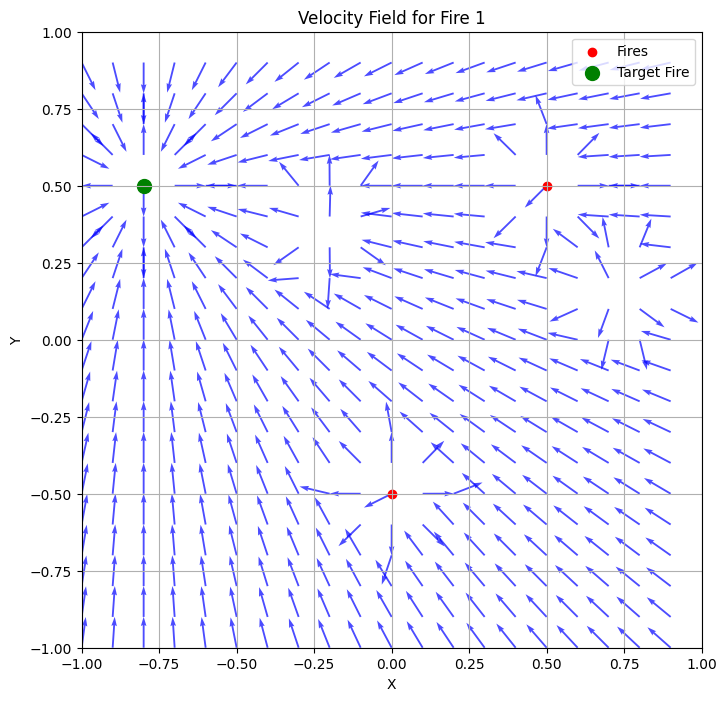

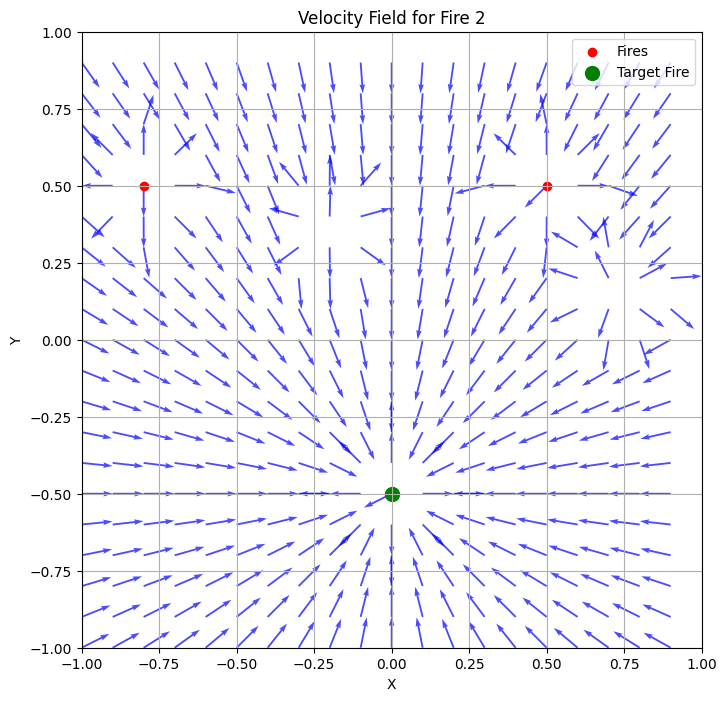

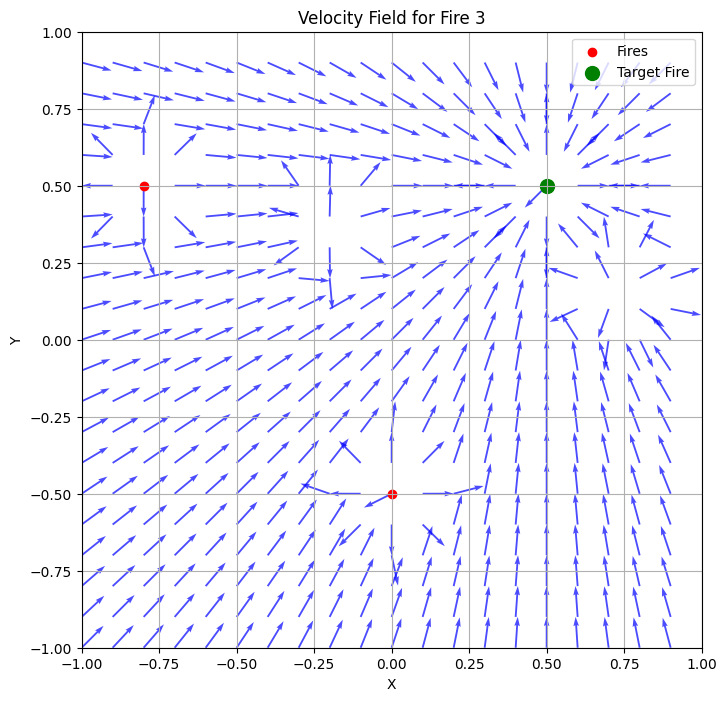

In [2]:
# Visualize velocity vectors on the grid for every fire_index
grid_resolution = 0.1
x_grid = np.arange(x_min, x_max, grid_resolution)
y_grid = np.arange(y_min, y_max, grid_resolution)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)

for current_fire_index in range(len(fires)):
    u = np.zeros_like(x_mesh)
    v = np.zeros_like(y_mesh)

    for i in range(x_mesh.shape[0]):
        for j in range(x_mesh.shape[1]):
            position = np.array([x_mesh[i, j], y_mesh[i, j]])
            # Attractive force toward the current fire
            f_att = attractive_force(position, fires[current_fire_index].flatten())
            
            # Repulsive force from other fires (excluding current target fire)
            other_fires = [fire for k, fire in enumerate(fires) if k != current_fire_index and fire_status[k] > fire_threshold]
            concatenated_obstacles = np.hstack([tree_positions, *fires]) if fires else tree_positions
            # concatenated_fires = np.hstack(other_fires) if other_fires else np.empty((2, 0))
            f_rep = repulsive_force(position, concatenated_obstacles, fires, sensing_radius)
            
            # Combine forces
            f_total = f_att + f_rep
            u[i, j] = f_total[0]
            v[i, j] = f_total[1]

    # Normalize velocity vectors for better visualization
    magnitude = np.sqrt(u**2 + v**2)
    u = np.divide(u, magnitude, out=np.zeros_like(u), where=magnitude > 0)
    v = np.divide(v, magnitude, out=np.zeros_like(v), where=magnitude > 0)

    # Plot the velocity vectors using quiver
    plt.figure(figsize=(8, 8))
    plt.quiver(x_mesh, y_mesh, u, v, scale=20, color='blue', alpha=0.7)
    plt.scatter([fire[0, 0] for fire in fires], [fire[1, 0] for fire in fires], color='red', label='Fires')
    plt.scatter(fires[current_fire_index][0, 0], fires[current_fire_index][1, 0], color='green', label='Target Fire', s=100)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(f'Velocity Field for Fire {current_fire_index + 1}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.show()
